## NLP (Natural Language Processing) with Python

In [1]:
import nltk

In [2]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]
print(len(messages))

5574


In [3]:
for msg_no,msg in enumerate(messages[:10]):
    print(msg_no,msg)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code 

Due to the spacing we can tell that this is a TSV ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself.

Using these labeled ham and spam examples, we'll train a machine learning model to learn to discriminate between ham/spam automatically.

Then, with a trained model, we'll be able to classify arbitrary unlabeled messages as ham or spam.

In [4]:
import pandas as pd
import numpy as np


In [5]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep= '\t', names =['label','message'])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Exploratory Data Analysis

In [6]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
#lets group by label and check the describe
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Let's make a new column to detect how long the text messages are:

In [8]:
messages['length'] = messages['message'].apply(len)

In [9]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


## Data Visualization

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

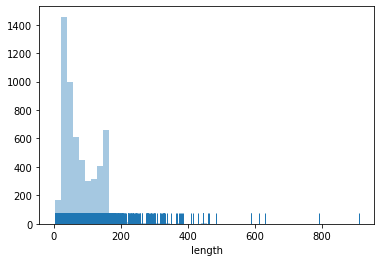

In [11]:
sns.distplot(messages['length'], kde=False, rug=True,bins = 50)

Let's explore  why the x-axis goes all the way to 1000,there is some really long message!

In [12]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [13]:
messages[messages['length'] == 910 ]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1227375c0>,
      dtype=object)

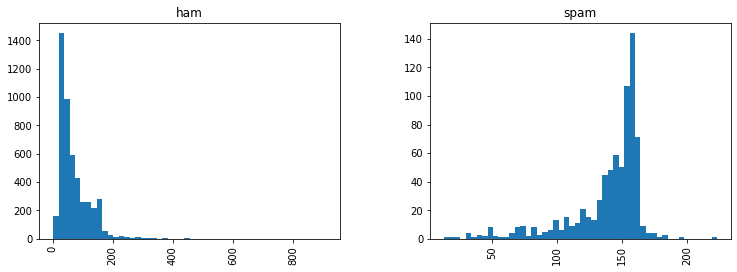

In [14]:
messages.hist(column='length', by='label', bins = 50, figsize=(12,4))

hrough just basic EDA we've been able to discover a trend that spam messages tend to have more characters.

Now let's begin to process the data so we can eventually use it with SciKit Learn!

## Text Pre-processing

In [15]:
from nltk.corpus import stopwords

In [16]:
import string
def processing_text(msg):
    """
    1. Rmoving the punctuation
    2. Remove all stopwords
    3. Return list of clean text
    """
    #remove puntuation marks
    no_punc = [m for m in msg if m not in string.punctuation]
    #joing the string again
    no_punc = ''.join(no_punc)
    #removing any stop words and returning the words
    return [w for w in no_punc.split() if w.lower() not in stopwords.words('english')]

In [17]:
#chekcing the function preprocessing_text
messages['message'].head(5).apply(processing_text)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

## Vectorization the words

Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
bag_words_transform = CountVectorizer(analyzer=processing_text).fit(messages['message'])
##checking total number of vocabulary
print(len(bag_words_transform.vocabulary_))

11425


In [20]:
msg4 = messages['message'][3]
msg4

'U dun say so early hor... U c already then say...'

In [21]:
messages_bag_w = bag_words_transform.transform(messages['message'])

In [22]:
print('shape of sparse matrix:',messages_bag_w.shape)
print('Amount of non zero occurences',messages_bag_w.nnz)

shape of sparse matrix: (5572, 11425)
Amount of non zero occurences 50548


In [23]:
sparsity = (100.0 * messages_bag_w.nnz / (messages_bag_w.shape[0] * messages_bag_w.shape[1]))
print('sparsity: {}'.format((sparsity)))

sparsity: 0.07940295412668218


## Weighting and normalization by TF-IDF, using scikit-learn's TfidfTransformer.

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_trans = TfidfTransformer().fit(messages_bag_w)
messages_tfidf = tfidf_trans.transform(messages_bag_w)

In [25]:
print(messages_tfidf.shape)

(5572, 11425)


## Training a model

In [26]:
from sklearn.naive_bayes import MultinomialNB
spam_detection_model = MultinomialNB().fit(messages_tfidf,messages['label'])

## Model Evaluation

In [27]:
all_predictions = spam_detection_model.predict(messages_tfidf)

In [28]:
from sklearn.metrics import classification_report
print (classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



In the above "evaluation",we evaluated accuracy on the same data we used for training. Lets split the train data and test data.

## Train Test Split

In [33]:
from sklearn.model_selection import train_test_split

msg_train,msg_test,label_train,label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572).

## Creating a Data Pipeline


Let's run our model again and then predict off the test set. We will use SciKit Learn's pipeline capabilities to store a pipeline of workflow

In [34]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('bag',CountVectorizer(analyzer=processing_text)),# strings to token integer counts
    ('tfidf',TfidfTransformer()),# integer counts to weighted TF-IDF scores
    ('classifier',MultinomialNB())# train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us!

In [35]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
         steps=[('bag',
                 CountVectorizer(analyzer=<function processing_text at 0x122a288c8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [36]:
predictions = pipeline.predict(msg_test)

In [37]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.95      0.98       997
        spam       0.72      1.00      0.84       118

    accuracy                           0.96      1115
   macro avg       0.86      0.98      0.91      1115
weighted avg       0.97      0.96      0.96      1115



In [38]:
#lets try random forest classifier
from sklearn.ensemble import RandomForestClassifier
pipe_randomForest = Pipeline([
    ('bag',CountVectorizer(analyzer=processing_text)),# strings to token integer counts
    ('tfidf',TfidfTransformer()),# integer counts to weighted TF-IDF scores
    ('classifier',RandomForestClassifier())# train on TF-IDF vectors w/ Naive Bayes classifier
])

In [40]:
pipe_randomForest.fit(msg_train,label_train)

/Library/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('bag',
                 CountVectorizer(analyzer=<function processing_text at 0x122a288c8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                              

In [41]:
predictions_random = pipeline.predict(msg_test)

In [42]:
print(classification_report(predictions_random,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.95      0.98       997
        spam       0.72      1.00      0.84       118

    accuracy                           0.96      1115
   macro avg       0.86      0.98      0.91      1115
weighted avg       0.97      0.96      0.96      1115

